# Imports

In [15]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# just for the sake of this blog post!
from warnings import filterwarnings
filterwarnings('ignore')


# Preprocess data

In [16]:


from sklearn.preprocessing import StandardScaler
from scipy import stats

def preprocess_data(data_path, labels_path=None):
    features = ['reanalysis_specific_humidity_g_per_kg', 
                 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c',
                'precipitation_amt_mm', 
                'week_start_date']
    df = pd.read_csv(data_path, index_col=[0, 1, 2])
            
    df['station_avg_temp_c_mv_avg'] = df['station_avg_temp_c'].rolling(window=5).mean()
    df['precipitation_amt_mm_mv_avg'] = df['precipitation_amt_mm'].rolling(window=5).mean()
    features.append('station_avg_temp_c_mv_avg')
    features.append('precipitation_amt_mm_mv_avg')
    
    df.fillna(method='ffill', inplace=True)
    df = df.fillna(df.mean())
    
    df['week_start_date'] = pd.to_datetime(df['week_start_date'])
    for i in range(1,5):
        df['quarter_' + str(i)] = df['week_start_date'].apply(lambda date: 1 if (
            ((i-1)*3<date.to_datetime().month) and (date.to_datetime().month <= i * 3)) else 0)
        features.append('quarter_' + str(i))
    
    df = df.drop(['week_start_date'], axis=1)
    features.remove('week_start_date')
    df = df[features]    
    sj_label = None
    iq_label = None
    # add labels to dataframe
    if labels_path:
        labels = pd.read_csv(labels_path, index_col=[0, 1, 2]).loc[df.index]
        sj_label = pd.DataFrame(labels.loc['sj'])
        iq_label = pd.DataFrame(labels.loc['iq'])

    sj = pd.DataFrame(df.loc['sj'])
    iq = pd.DataFrame(df.loc['iq'])
    
    
    return sj, iq, sj_label, iq_label

In [17]:
sj_train, iq_train, sj_label, iq_label = preprocess_data('./data/train_features.csv', './data/train_labels.csv')
sj_train.head()

reanalysis_specific_humidity_g_per_kg  \
year weekofyear                                          
1990 18                                      14.012857   
     19                                      15.372857   
     20                                      16.848571   
     21                                      16.672857   
     22                                      17.210000   

                 reanalysis_dew_point_temp_k  station_avg_temp_c  \
year weekofyear                                                    
1990 18                           292.414286           25.442857   
     19                           293.951429           26.714286   
     20                           295.434286           26.714286   
     21                           295.310000           27.471429   
     22                           295.821429           28.942857   

                 precipitation_amt_mm  station_avg_temp_c_mv_avg  \
year weekofyear                                                    
1990 18                         12.42                  27.187384   
     19                         22.82                  27.187384   
     20                         34.54                  27.187384   
     21                         15.36                  27.187384   
     22                          7.52                  27.057143   

                 precipitation_amt_mm_mv_avg  quarter_1  quarter_2  quarter_3  \
year weekofyear                                                                 
1990 18                            45.881722          0          1          0   
     19                            45.881722          0          1          0   
     20                            45.881722          0          1          0   
     21                            45.881722          0          1          0   
     22                            18.532000          0          1          0   

                 quarter_4  
year weekofyear             
1990 18                  0  
     19                  0  
     20                  0  
     21                  0  
     22                  0

# Split validation and training

In [18]:
from sklearn.model_selection import train_test_split

# split data into training and validation data, for both predictors and target
# The split is based on a random number generator. Supplying a numeric value to
# the random_state argument guarantees we get the same split every time we
# run this script.

# sj_train.head()

sj_train_X, sj_test_X, sj_train_y, sj_test_y = train_test_split(sj_train, sj_label['total_cases'], test_size=0.1, random_state=0, shuffle=False)

iq_train_X, iq_test_X, iq_train_y, iq_test_y = train_test_split(iq_train, iq_label['total_cases'], test_size=0.25, random_state=0, shuffle=False)
sj_train_X['total_cases'] = sj_train_y
sj_test_X['total_cases'] = sj_test_y

iq_train_X['total_cases'] = iq_train_y
iq_test_X['total_cases'] = iq_test_y

sj_train_X.head()


reanalysis_specific_humidity_g_per_kg  \
year weekofyear                                          
1990 18                                      14.012857   
     19                                      15.372857   
     20                                      16.848571   
     21                                      16.672857   
     22                                      17.210000   

                 reanalysis_dew_point_temp_k  station_avg_temp_c  \
year weekofyear                                                    
1990 18                           292.414286           25.442857   
     19                           293.951429           26.714286   
     20                           295.434286           26.714286   
     21                           295.310000           27.471429   
     22                           295.821429           28.942857   

                 precipitation_amt_mm  station_avg_temp_c_mv_avg  \
year weekofyear                                                    
1990 18                         12.42                  27.187384   
     19                         22.82                  27.187384   
     20                         34.54                  27.187384   
     21                         15.36                  27.187384   
     22                          7.52                  27.057143   

                 precipitation_amt_mm_mv_avg  quarter_1  quarter_2  quarter_3  \
year weekofyear                                                                 
1990 18                            45.881722          0          1          0   
     19                            45.881722          0          1          0   
     20                            45.881722          0          1          0   
     21                            45.881722          0          1          0   
     22                            18.532000          0          1          0   

                 quarter_4  total_cases  
year weekofyear                          
1990 18                  0            4  
     19                  0            5  
     20                  0            4  
     21                  0            3  
     22                  0            6

# Train Model

In [27]:
from statsmodels.tools import eval_measures
import statsmodels.formula.api as smf

def get_best_model(train, test):
    # Step 1: specify the form of the model
    model_formula = "total_cases ~ 1 + " \
                    "reanalysis_specific_humidity_g_per_kg + " \
                    "reanalysis_dew_point_temp_k + " \
                    "station_avg_temp_c + " \
                    "precipitation_amt_mm + " \
    "station_avg_temp_c_mv_avg + " \
    "precipitation_amt_mm_mv_avg " \
    
    
    grid = 10 ** np.arange(-8, -3, dtype=np.float64)
                    
    best_alpha = []
    best_score = 1000
        
    # Step 2: Find the best hyper parameter, alpha
    for alpha in grid:
        model = smf.glm(formula=model_formula,
                        data=train,
                        family=sm.families.NegativeBinomial(alpha=alpha))

        results = model.fit()
        predictions = results.predict(test).astype(int)
        score = eval_measures.meanabs(predictions, test.total_cases)

        if score < best_score:
            best_alpha = alpha
            best_score = score

    print('best alpha = ', best_alpha)
    print('best score = ', best_score)
            
    # Step 3: refit on entire dataset
    full_dataset = pd.concat([train, test])
    model = smf.glm(formula=model_formula,
                    data=full_dataset,
                    family=sm.families.NegativeBinomial(alpha=best_alpha))

    fitted_model = model.fit()
    return fitted_model

sj_best_model = get_best_model(sj_train_X, sj_test_X)
iq_best_model = get_best_model(iq_train_X, iq_test_X)


best alpha =  1e-08
best score =  22.680851063829788
best alpha =  1e-08
best score =  8.138461538461538


# Plot predictions

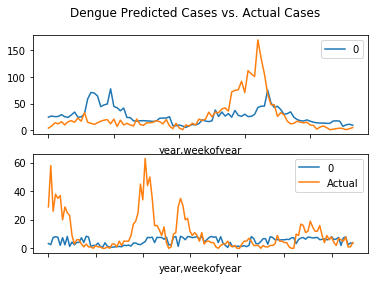

In [6]:
figs, axes = plt.subplots(nrows=2, ncols=1)

# plot sj
pd.DataFrame(sj_pred_val).plot(ax=axes[0], label="Predictions")
sj_test_y.plot(ax=axes[0], label="Actual")

# plot iq
pd.DataFrame(iq_pred_val).plot(ax=axes[1], label="Predictions")
iq_test_y.plot(ax=axes[1], label="Actual")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()

# Save predictions

In [ ]:

sj_test, iq_test, sj_test_label, iq_test_label = preprocess_data('./data/dengue_features_test.csv')

sj_predictions = sj_model.predict(sj_test).astype(int)
iq_predictions = iq_model.predict(iq_test).astype(int)

submission = pd.read_csv("./data/submission .csv", index_col=[0, 1, 2])

submission.total_cases = np.concatenate([sj_predictions, iq_predictions])

submission.to_csv("./results/2_submission_latest.csv")

# Compare benchmarks

Comparison : MAE : 1.5240384615384615


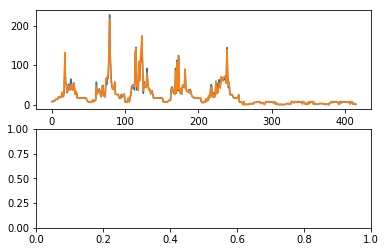

In [8]:
benchmark = pd.read_csv('./results/best.csv')
submission = pd.read_csv('./results/2_submission_latest.csv')


# adder = lambda x: x + 10
# formated_total_cases = submission['total_cases'].apply(adder)

# print(formated_total_cases)

figs, axes = plt.subplots(nrows=2, ncols=1)

# # submission = submission.iloc[50:]
# plot sj
benchmark.total_cases.plot(ax=axes[0], label="Actual")
submission.total_cases.plot(ax=axes[0], label="Predictions")
    

# plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
# plt.legend()

# plt.show()

print("Comparison : MAE : " + str(mean_absolute_error(benchmark.total_cases, submission.total_cases)))